<a href="https://colab.research.google.com/github/jay10440/play-statistical-projects/blob/main/Fractal_Predictive_Practice_Fake_Hurricane_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'm still very interested in hurricane analysis, but I wanted to spend some time getting used to doing fractal predictive analysis with time series. I will generate some fake data and see if there are any cool trends that comes up from a data set that "might" be fractal.

In [1]:
#Starting with our forecast , time series and fractal packages
#I get to use a new trick here!
install.packages(c("pracma","fractal","tseries","fracdiff","forecast","boot"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘fractal’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
also installing the dependencies ‘xts’, ‘TTR’, ‘quadprog’, ‘zoo’, ‘quantmod’, ‘colorspace’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘RcppArmadillo’




Time to cook up some data.

In [3]:
library(fracdiff)
set.seed(123)
model <- fracdiff.sim(n=50, d=.3)
series<- model$series
series

[1] -0.64307249 -0.51421763  1.29551491  0.36130732  0.31587558  1.90078351
 [7]  1.13963961 -0.65042226 -0.60247110 -0.51818974  1.09918170  0.68422427
[13]  0.74225394  0.50033260 -0.21253965  1.91422706  1.19539282 -1.30560201
[19]  0.63383296 -0.19631673 -0.96865674 -0.40831444 -1.16297118 -1.10393085
[25] -1.07743123 -2.18657805 -0.03143595 -0.21221802 -1.42244281  0.65172594
[31]  0.34809692 -0.30230627  0.74728428  1.01597191  1.14027559  1.13116396
[37]  1.06285580  0.47310295  0.07952001 -0.15189629 -0.59287142 -0.29332147
[43] -1.34074177  1.76415564  1.61285047 -0.51254154 -0.31512836 -0.46781579
[49]  0.68203166  0.11630439

So here, the cut function takes your data and breaks it into equal chunks, chunks that are based on how you want them cut. For example, we're using quantile cuts out of our series shown below which will help us cut our data points to nearly equal sizes. We will categorize the bins from 1 to 5, load the series into the bins so that the output of the cat_data that came from the series will spit out the bins, then use that as a time series with a "similar" structure to try to get something that may be fractal like.

[1] 1 2 5 3 3 5 5 1 2 2 5 4 4 4 3 5 5 1 4 3 1 2 1 1 1 1 3 3 1 4 3 2 4 4 5 5 4 4
[39] 3 3 2 2 1 5 5 2 2 2 4 3

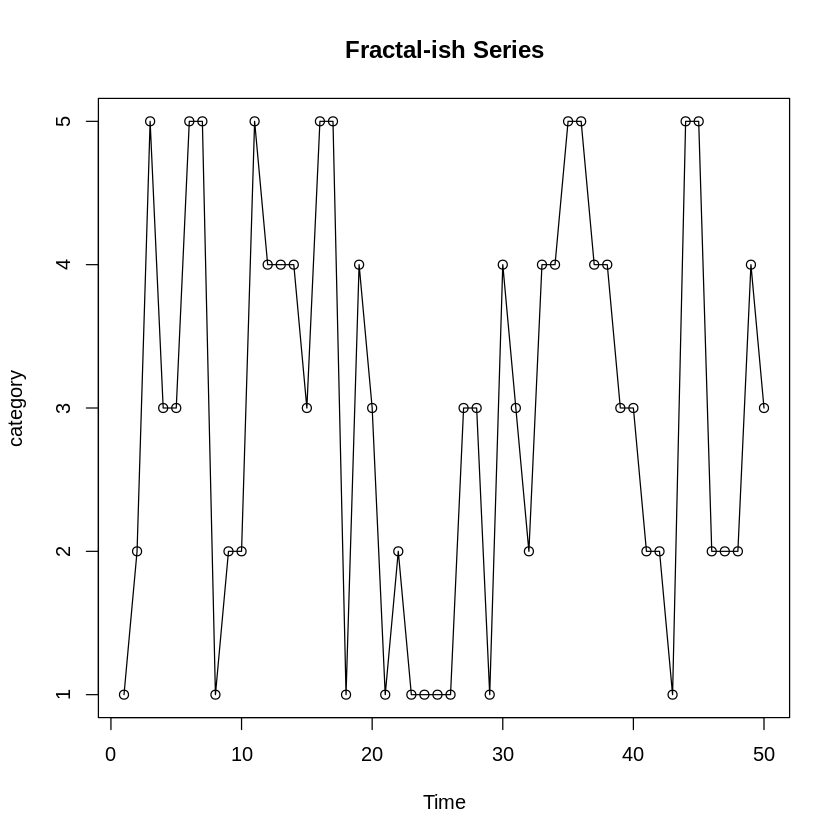

In [7]:
cat_data<- cut(
  series,
  breaks=quantile(series, probs=seq(0,1,0.2)),
  labels=1:5,
  include.lowest=TRUE
)
cat_data<- as.integer(cat_data)
cat_data

plot.ts(cat_data, type="o", main="Fractal-ish Series", ylab="category")

So far, this doesn't tell us much, because of the time. Of course, the categories make sense. Let's make this wild. Let's say this is a period of 3 months!

In [14]:
install.packages(c("zoo","lubridate","pacman"))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



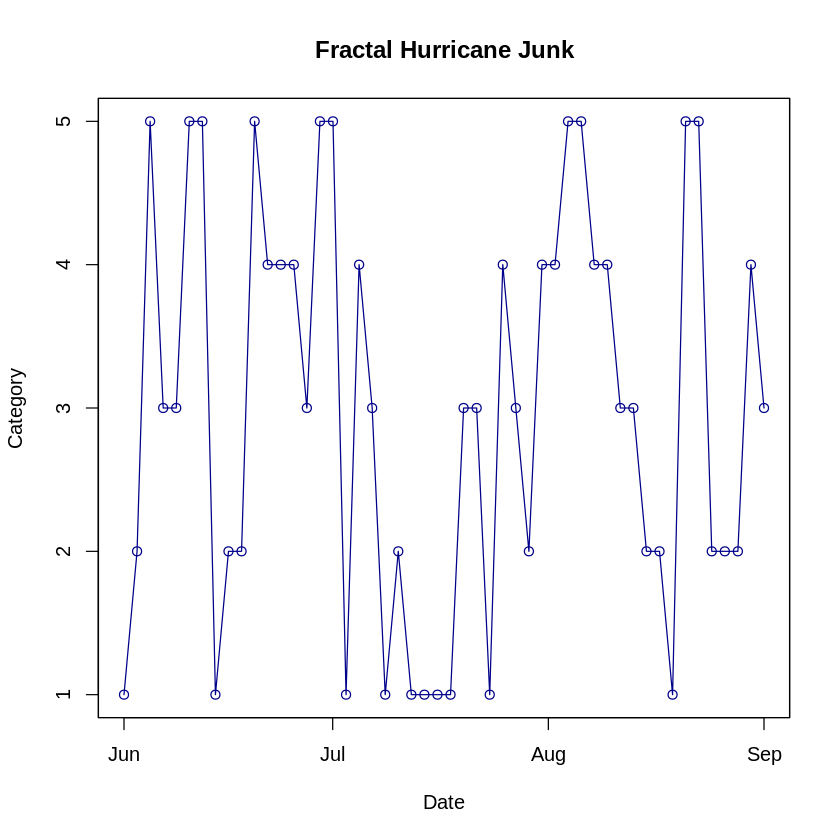

In [16]:
library(zoo)
library(lubridate)

#Starting the Dates:
start_date<- as.Date("2024-06-01")
end_date<- as.Date("2024-09-01")

#Timestamps
time_index<- seq(from= start_date, to = end_date, length.out =length(cat_data))
ts_zoo <- zoo(cat_data, order.by = time_index)

#Plot
plot(ts_zoo, type="o", col="darkblue",
 main="Fractal Hurricane Junk", xlab="Date", ylab="Category")

So, it's often good to be able to analyze this time series in different ways. For things like storms, hurricanes, etc, if we're looking at overall climate data, we sometimes would look at longer scale vs shorter scale.

The autocorrelation function is good for telling us information about shorter scale. However, the Hurst exponential gives us an idea on whether or not our data might be closely related to some functionality via a power law. If it does, this suggests that the data would show self similarity (as power law relations does this) and would suggest our data could be fractal. To do our due diligence, we first compute the autocorrelation function of this time series, then calculate the Hurst exponent.

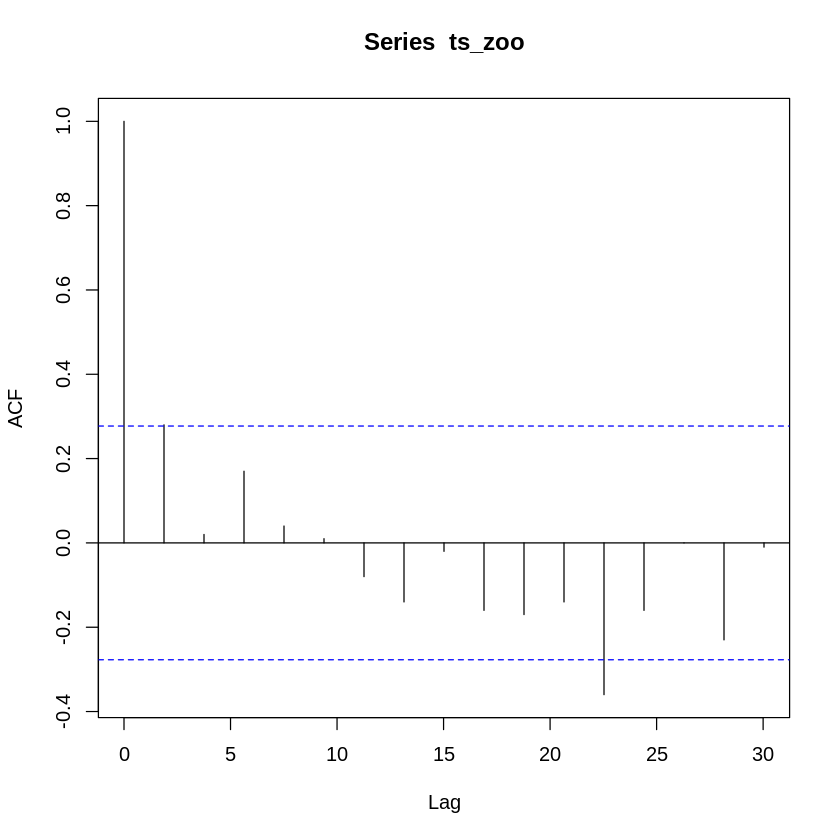

In [17]:
#Autocorrelation Function
acf(ts_zoo)

There isn't really much to go off of here, maybe boostrapping the data later could be useful. In any case, let's take a look at the long term:

In [19]:
library(pracma)
hurst_exponent <- hurstexp(cat_data)
print(hurst_exponent)

Simple R/S Hurst estimation:         0.5834276 
Corrected R over S Hurst exponent:   0.6684453 
Empirical Hurst exponent:            0.5311861 
Corrected empirical Hurst exponent:  0.4688004 
Theoretical Hurst exponent:          0.5861637 
$Hs
[1] 0.5834276

$Hrs
[1] 0.6684453

$He
[1] 0.5311861

$Hal
[1] 0.4688004

$Ht
[1] 0.5861637



As we can see, the hurst exponential is near 5. The only one that seems to suggest some kind of long-term dependence is the Hrs value, and it's not much higher. At this point, we can extend the data a bit. On to the resampling! But we have to be careful how we do this. This isn't an ordinary set of events, but these have time dependence, so we're thankful we have functions to deal with this, tsboot!

In [23]:
library(boot)
r<- 5
n<- length(cat_data)
set.seed(123)
boot_blocks<- tsboot(ts=cat_data, statistic=function(x) x, R=1, l=r, sim="fixed")
boot_cat<- boot_blocks$t
boot_cat

3,2,4,4,5,3,5,5,1,4,⋯,4,3,5,5,1,1,1,3,3,1


The reason blocks were used above is so that we can preserve some temporal structure. If we did a normal boostrap, due to how resampling works with boostraping, it could wipe any fractality out.

In [24]:
hurstexp(boot_cat)

Simple R/S Hurst estimation:         0.5291973 
Corrected R over S Hurst exponent:   0.6797734 
Empirical Hurst exponent:            0.6037869 
Corrected empirical Hurst exponent:  0.5163073 
Theoretical Hurst exponent:          0.5861637 
